# Thực hành MHNC Lab 03
## Nguyễn Minh Hoàng 18110095

In [1]:
import tensorflow as tf
import os 
import random 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
                Input, Dense, 
                Flatten, Reshape
                )
from tensorflow.keras import initializers
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt


### 1. Hãy tạo ra một block DoubleConvMaxpool gồm 2 lớp ConvMaxpool có số filters lần lượt là 16, 32, và một block DoubleFC có số hidden nodes lần lượt là 100, 50.

In [2]:
@tf.keras.utils.register_keras_serializable()
class DoubleLinear(tf.keras.layers.Layer):
    def __init__(self, units, activations, **kwargs):
        self.units = units 
        self.activations = activations
        super(DoubleLinear, self).__init__(**kwargs)
    def build(self, input_shape):
        self.unit1, self.unit2 = self.units
        self.activation1 = tf.keras.activations.get(self.activations[0])
        self.activation2 = tf.keras.activations.get(self.activations[1])

        self.w1 = self.add_weight(shape=(input_shape[-1], self.unit1),
                                 initializer = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
                                 trainable=True,
                                 name="W1") 
        self.b1 = self.add_weight(shape=(self.unit1,),
                                 initializer=initializers.Zeros(),
                                 trainable=True,
                                 name="b1")
        
        self.w2 = self.add_weight(shape=(self.unit1, self.unit2),
                                 initializer = initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
                                 trainable=True,
                                 name="W2") 
        self.b2 = self.add_weight(shape=(self.unit2,),
                                 initializer= initializers.Zeros(),
                                 trainable=True,
                                 name="b2")
    def call(self, inputs):
        x = self.activation1(K.dot(inputs , self.w1) + self.b1)
        x = self.activation2(K.dot(x , self.w2) + self.b2)
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'units': self.units,
            'activations': self.activations,
        })
        return config

@tf.keras.utils.register_keras_serializable()
class DoubleConvMaxpool(tf.keras.layers.Layer):
    def __init__(self, filter_size, n_filters, activations,**kwargs):
        self.filter_size = filter_size 
        self.n_filters = n_filters
        self.activations = activations
        super(DoubleConvMaxpool, self).__init__(**kwargs)
    def build(self, input_shape):

        self.filter_size1, self.filter_size2 = self.filter_size
        self.n_filters1, self.n_filters2 = self.n_filters
        self.activation1 = tf.keras.activations.get(self.activations[0])
        self.activation2 = tf.keras.activations.get(self.activations[1])

        self.kernel1 = self.add_weight(name="kernel1",
                                      shape=(self.filter_size1[0], self.filter_size1[1], input_shape[-1], self.n_filters1),
                                      initializer= initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
                                      trainable=True)
        self.bias1 = self.add_weight(name="bias1",
                                      shape=(1,self.n_filters1),
                                      initializer= initializers.Zeros(),
                                      trainable=True)
        

        self.kernel2 = self.add_weight(name="kernel2",
                                      shape=(self.filter_size2[0], self.filter_size2[1], self.n_filters1, self.n_filters2),
                                      initializer= initializers.TruncatedNormal(mean=0.0, stddev=0.05, seed=42),
                                      trainable=True)
        self.bias2 = self.add_weight(name="bias2",
                                      shape=(1,self.n_filters2),
                                      initializer= initializers.Zeros(),
                                      trainable=True)
    def call(self, inputs):
        x = self.activation1(
                     K.conv2d(x = inputs,
                     kernel = self.kernel1,
                     padding = "same") + self.bias1)
        x = K.pool2d(x, 
                     pool_size = (2,2),
                     strides = (2,2),
                     pool_mode = "max")
        x = self.activation2(
                     K.conv2d(x = x,
                     kernel = self.kernel2,
                     padding = "same") + self.bias2)
        x = K.pool2d(x, 
                     pool_size = (2,2),
                     strides = (2,2),
                     pool_mode = "max")
        return x

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filter_size': self.filter_size,
            'n_filters': self.n_filters,
            'activations': self.activations
        })
        return config

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test
Mỗi ảnh có một kênh màu, kích thước 28x28

Ảnh đầu tiên của tập train
Label đầu tiên của tập train:  5


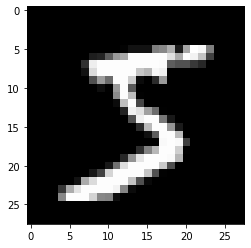

In [3]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train, X_test = X_train/255.0, X_test/255.0

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print("Có 60000 ảnh dùng để train và valid, 10000 ảnh dùng để test")
print("Mỗi ảnh có một kênh màu, kích thước 28x28")
print()

print("Ảnh đầu tiên của tập train")
print("Label đầu tiên của tập train: ", y_train[0])
plt.imshow(X_train[0], cmap='gray')
plt.show()
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1,
                                                      random_state = 0)

### 2. Tạo ra model, train, và test trên tập mnist như hình bên dưới: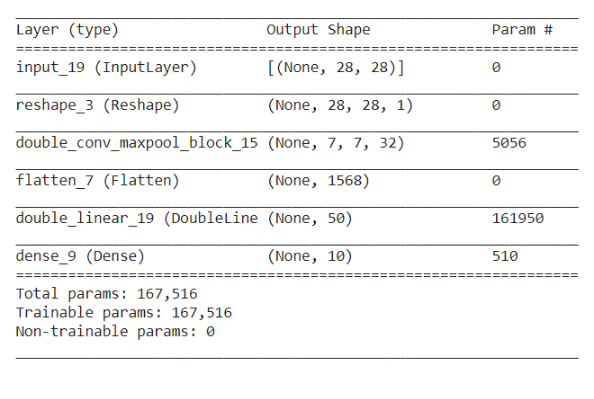

In [4]:

def set_seed(seed_value):
  # Hàm này dùng để chỉnh seed về con số cố định và giúp ta có thể reproduce kết quả
  os.environ['PYTHONHASHSEED']=str(seed_value)
  random.seed(seed_value)
  np.random.seed(seed_value)
  tf.random.set_seed(seed_value)
  session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
  sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
  tf.compat.v1.keras.backend.set_session(sess)

def get_model():
  set_seed(0)
  inputs = Input(shape=(28,28))

  x = Reshape(target_shape = (28,28,1))(inputs)
  x = DoubleConvMaxpool(filter_size = [(5,5),(3,3)],
                        n_filters = [16,32],
                        activations = ['relu', 'relu'])(x)
  x = Flatten()(x)
  x = DoubleLinear(units = [100,50],
                    activations = ['relu', 'relu'])(x)     
  outputs = Dense(units = 10, activation = 'softmax')(x)

  model = Model(inputs = inputs , outputs = outputs)
  return model

model = get_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
double_conv_maxpool (DoubleC (None, 7, 7, 32)          5056      
_________________________________________________________________
flatten (Flatten)            (None, 1568)              0         
_________________________________________________________________
double_linear (DoubleLinear) (None, 50)                161950    
_________________________________________________________________
dense (Dense)                (None, 10)                510       
Total params: 167,516
Trainable params: 167,516
Non-trainable params: 0
_______________________________________________________

In [5]:
model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate= 2e-3, name='RMSprop'),
              metrics=['accuracy']
              )

mc = tf.keras.callbacks.ModelCheckpoint(filepath="epoch: {epoch:02d}.hdf5", 
                                     monitor='val_accuracy',
                                     mode='max', 
                                     verbose=1,
                                     save_best_only=True)
history = model.fit(X_train, y_train,
                    batch_size= 100,
                    epochs= 10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])      


Epoch 1/10
540/540 [==============================] - 47s 85ms/step - loss: 0.2097 - accuracy: 0.9331 - val_loss: 0.0512 - val_accuracy: 0.9830

Epoch 00001: val_accuracy improved from -inf to 0.98300, saving model to epoch: 01.hdf5
Epoch 2/10
540/540 [==============================] - 45s 84ms/step - loss: 0.0536 - accuracy: 0.9840 - val_loss: 0.0318 - val_accuracy: 0.9900

Epoch 00002: val_accuracy improved from 0.98300 to 0.99000, saving model to epoch: 02.hdf5
Epoch 3/10
540/540 [==============================] - 45s 84ms/step - loss: 0.0374 - accuracy: 0.9891 - val_loss: 0.0394 - val_accuracy: 0.9892

Epoch 00003: val_accuracy did not improve from 0.99000
Epoch 4/10
540/540 [==============================] - 45s 84ms/step - loss: 0.0293 - accuracy: 0.9915 - val_loss: 0.0299 - val_accuracy: 0.9903

Epoch 00004: val_accuracy improved from 0.99000 to 0.99033, saving model to epoch: 04.hdf5
Epoch 5/10
540/540 [==============================] - 46s 84ms/step - loss: 0.0241 - accuracy: 

In [6]:
#ta chọn epoch thứ 30 làm best model
model = tf.keras.models.load_model("/content/epoch: 10.hdf5")
result = model.evaluate(X_test,y_test)
print("loss và accuracy trên tập test là {} {}".format(result[0],result[1]))

313/313 [==============================] - 3s 10ms/step - loss: 0.0414 - accuracy: 0.9916
loss và accuracy trên tập test là 0.041364725679159164 0.991599977016449
